# Bitcoin Price Direction Prediction: The Quest for the Crystal Ball

## Introduction
Cryptocurrency trading has emerged as one of the most captivating and accessible financial activities of our time. It offers a landscape of unlimited potential, where fortunes can be made by those who can successfully navigate its volatility. The premise is simple yet elusive: if we knew when the price would go up or down, the profit potential would be infinite.

Every trader dreams of a "magic ball"—a predictive tool that cuts through the noise and signals the right moment to act. In this project, we attempt to engineer this magic ball using data science and machine learning.

We will not rely on gut feeling or drawing lines on a chart. Instead, we will use rigorous statistical methods, **XGBoost** classification, and **Hidden Markov Models (HMM)** to decode market regimes.

## Project Roadmap
1.  **Data Analysis**: We will prove why predicting the *exact price* (Regression) is nearly impossible due to market noise and non-stationarity.
2.  **Target Engineering**: We will define "Truth" using a zero-lag smoothing technique to label data as **UP**, **DOWN**, or **SIDEWAYS**.
3.  **Iterative Feature Engineering**:
    *   **Step 1**: Basic Technical Indicators (RSI, MACD).
    *   **Step 2**: Adding Market Microstructure (Volume Delta, Volatility).
    *   **Step 3**: Advanced Regime Modeling (Hidden Markov Models).
4.  **Model Training**: We will train an XGBoost classifier and optimize it.
5.  **Backtesting**: We will simulate trading this strategy with **Zero Commission**, mimicking a high-frequency or VIP trading environment.


In [ ]:
# Install necessary libraries if not present
# !conda install -c conda-forge hmmlearn -y
# !conda install -c conda-forge statsmodels -y


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import RobustScaler
from hmmlearn.hmm import GaussianHMM
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.stattools import adfuller
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
def load_and_merge_data(
    fundings_path: str = "data/processed/fundings.parquet",
    klines_path: str = "data/processed/klines_15min_all.parquet",
    volumes_path: str = "data/processed/aggtrades_15min_all.parquet",
) -> pd.DataFrame:
    """Loads and merges funding, klines, and volume data."""
    print("Loading data...")
    fundings = pd.read_parquet(fundings_path)
    klines = pd.read_parquet(klines_path)
    volumes = pd.read_parquet(volumes_path)

    if "datetime" in volumes.columns: volumes = volumes.rename(columns={"datetime": "time"})
    if "calc_time" in fundings.columns: fundings = fundings.rename(columns={"calc_time": "time"})
    if "open_time" in klines.columns: klines = klines.rename(columns={"open_time": "time"})

    for col in ["time"]:
        volumes[col] = pd.to_datetime(volumes[col], utc=True)
        fundings[col] = pd.to_datetime(fundings[col], utc=True)
        klines[col] = pd.to_datetime(klines[col], utc=True)

    df = pd.merge(volumes, klines, on="time", how="inner")
    df = pd.merge(df, fundings, on="time", how="left")

    df = df.sort_values("time").reset_index(drop=True)
    if "funding_rate" in df.columns:
        df["funding_rate"] = df["funding_rate"].ffill()
    
    print(f"Data loaded successfully. Shape: {df.shape}")
    return df


In [3]:
# Load the data
df = load_and_merge_data()
print(df.head())


Loading data...
Data loaded successfully. Shape: (64320, 16)
                       time  total_vol   bid_vol  max_bid_vol  mod_bid_vol  \
0 2024-01-01 00:00:00+00:00   3616.424  1254.573       50.010        0.003   
1 2024-01-01 00:15:00+00:00   2322.028  1229.331       39.160        0.003   
2 2024-01-01 00:30:00+00:00   1684.217   879.438       20.174        0.003   
3 2024-01-01 00:45:00+00:00    835.244   408.159       15.407        0.003   
4 2024-01-01 01:00:00+00:00    850.274   482.286       50.858        0.003   

   avg_bid_vol   ask_vol  max_ask_vol  mod_ask_vol  avg_ask_vol     open  \
0     0.118133  2361.851       73.934        0.003     0.222397  42314.0   
1     0.145707  1092.697       30.074        0.003     0.129513  42532.4   
2     0.136326   804.779       14.077        0.003     0.124753  42458.4   
3     0.117625   427.085       18.973        0.003     0.123079  42474.5   
4     0.140077   367.988       16.992        0.003     0.106880  42503.5   

      high   

## 1. Data Analysis: Stationarity & Regression Failure
#
### 1.1 Stationarity Check
Financial time series like Bitcoin prices are typically non-stationary (mean and variance change over time), making them unsuitable for direct prediction using many statistical models. Log-returns are usually stationary.
#
We will use the **Augmented Dickey-Fuller (ADF)** test to statistically prove this.


--- ADF Test for Close Price ---
ADF Statistic: -0.9890
p-value: 0.7573
Critical Values:
	1%: -3.4310
	5%: -2.8618
	10%: -2.5669
Result: Close Price is NON-STATIONARY (Fail to reject H0)


--- ADF Test for Log Returns ---
ADF Statistic: -32.4312
p-value: 0.0000
Critical Values:
	1%: -3.4310
	5%: -2.8618
	10%: -2.5669
Result: Log Returns is STATIONARY (Reject H0)




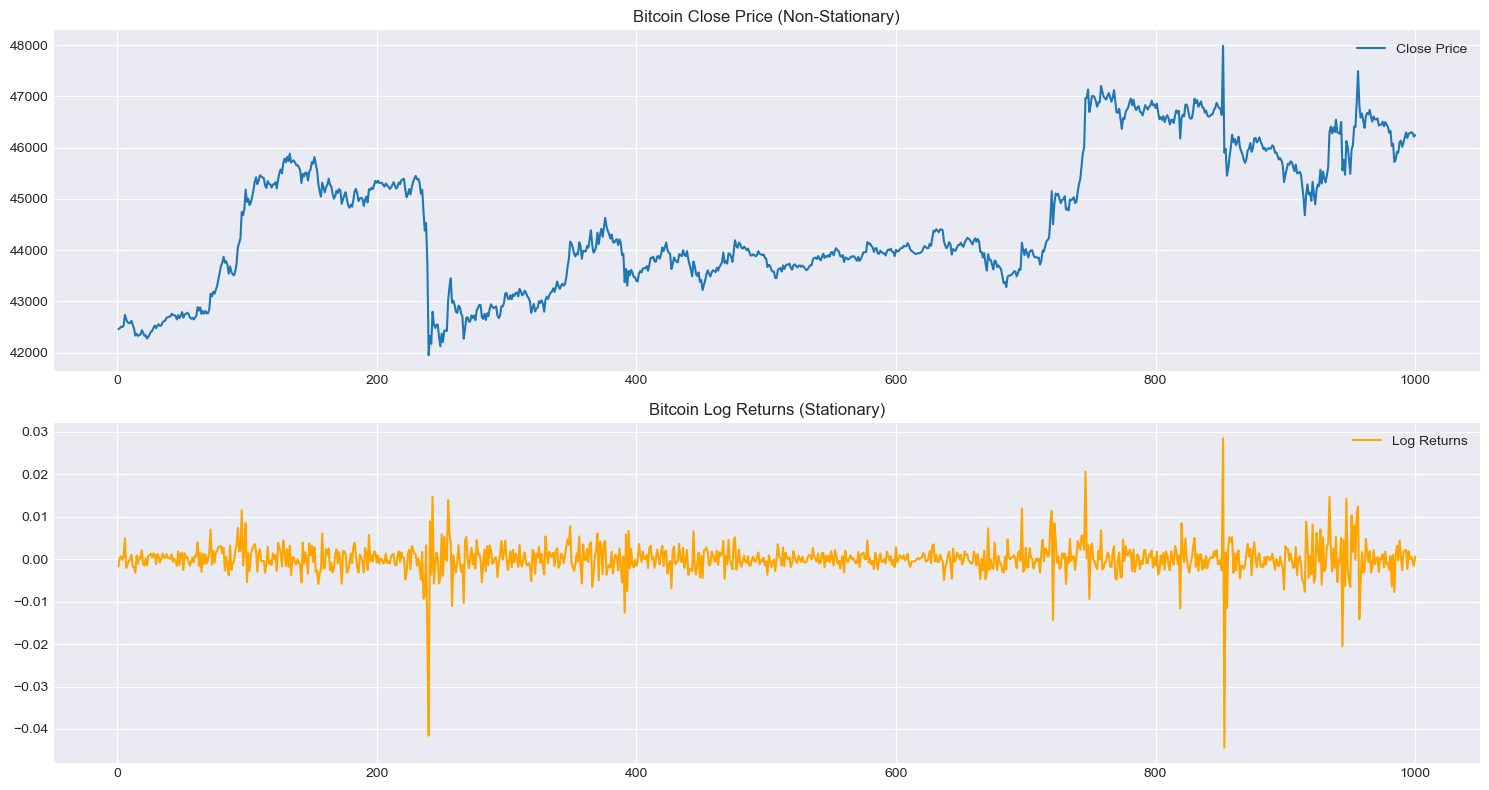

In [4]:
# Calculate Log Returns
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()

def check_stationarity(series, name="Series"):
    result = adfuller(series)
    print(f"--- ADF Test for {name} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"Result: {name} is STATIONARY (Reject H0)")
    else:
        print(f"Result: {name} is NON-STATIONARY (Fail to reject H0)")
    print("\n")

# Check Close Price
check_stationarity(df['close'].iloc[:10000], "Close Price")

# Check Log Returns
check_stationarity(df['log_return'].iloc[:10000], "Log Returns")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(df['close'].iloc[:1000], label='Close Price')
axes[0].set_title('Bitcoin Close Price (Non-Stationary)')
axes[0].legend()

axes[1].plot(df['log_return'].iloc[:1000], label='Log Returns', color='orange')
axes[1].set_title('Bitcoin Log Returns (Stationary)')
axes[1].legend()

plt.tight_layout()
plt.show()


### 1.2 Why Regression Fails
We will now train a simple XGBoost Regressor to predict the *next bar's log-return* using a small subset of data.
We expect the $R^2$ score to be close to zero (or negative), indicating that the model cannot predict the magnitude of price changes better than a simple mean baseline.


Regression MSE: 0.00000559
Regression R^2: -0.0425 (Expected to be near 0)


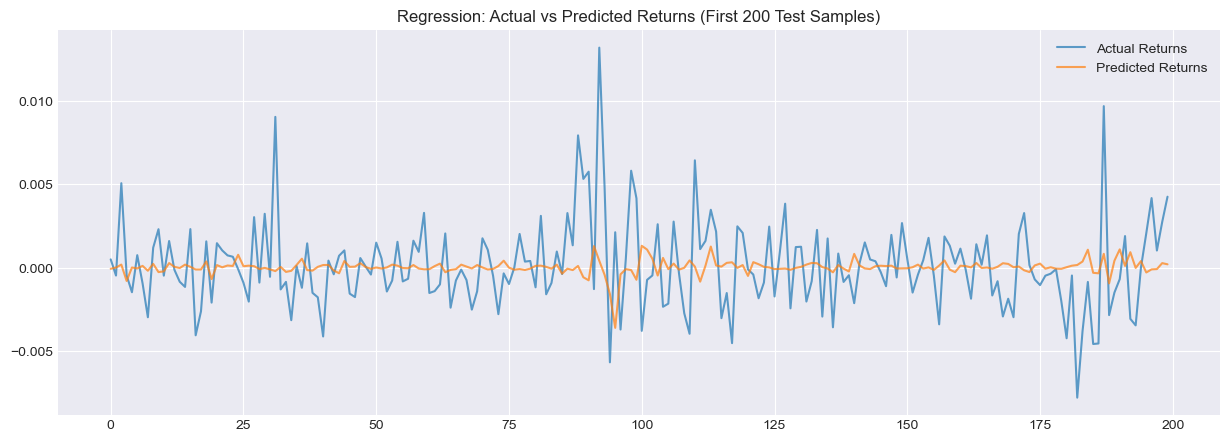

In [5]:
# Prepare data for regression demo (Subset)
subset_size = 5000
df_reg = df.iloc[:subset_size].copy()

# Features: Lagged returns
for i in range(1, 6):
    df_reg[f'lag_{i}'] = df_reg['log_return'].shift(i)

df_reg = df_reg.dropna()

X_reg = df_reg[[f'lag_{i}' for i in range(1, 6)]]
y_reg = df_reg['log_return'] # Predict next return

# Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, shuffle=False)

# Train Simple XGBoost Regressor
regressor = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Predict
y_pred_reg = regressor.predict(X_test_reg)

# Evaluate
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Regression MSE: {mse:.8f}")
print(f"Regression R^2: {r2:.4f} (Expected to be near 0)")

# Visualization
plt.figure(figsize=(15, 5))
plt.plot(y_test_reg.values[:200], label='Actual Returns', alpha=0.7)
plt.plot(y_pred_reg[:200], label='Predicted Returns', alpha=0.7)
plt.title('Regression: Actual vs Predicted Returns (First 200 Test Samples)')
plt.legend()
plt.show()


### Conclusion on Regression
The regression results confirm our suspicion. The $R^2$ score is extremely low, meaning the model fails to capture the *magnitude* of future price movements. Financial data is inherently noisy, and predicting the exact number is a fool's errand for a simple model.

**However**, we don't necessarily need to know if Bitcoin will go up by 0.5% or 0.6%. We just need to know **IF** it will go up or down. This realization leads us to **Classification**.


## 2. Target Generation: The "Oracle" Labeling

Since regression is difficult, we switch to **Classification** (Up/Down/Sideways).
To create high-quality labels, we use a **Centered Moving Average (Gaussian Smoothing)** on the *entire* dataset.

**Why?**
This creates a smooth trend line that uses future data (zero lag). This is valid for *target generation* because we want to teach the model what *actually happened*. We must ensure we **never** use this smoothed line as a feature.

**Classes:**
*   **2 (UP):** Slope > Threshold
*   **0 (DOWN):** Slope < -Threshold
*   **1 (SIDEWAYS):** |Slope| <= Threshold


In [6]:
def create_target_labels(df, sigma=1, threshold=0.0005):
    """
    Creates target labels using Gaussian smoothing (Centered MA).
    sigma: Controls smoothness (higher = smoother trend)
    threshold: Slope threshold for Up/Down classification
    """
    df_target = df.copy()

    # 1. Apply Gaussian Filter (Centered Smoothing)
    # This uses the entire series (future and past) to smooth.
    df_target['smoothed_close'] = gaussian_filter1d(
        df_target['close'],
        sigma=sigma
    )

    # 2. Calculate Slope (Derivative) of the smoothed line
    df_target['smooth_slope'] = np.diff(
        np.log(df_target['smoothed_close']),
        prepend=np.nan
    )

    # 3. Define Classes
    conditions = [
        df_target['smooth_slope'] > threshold,
        df_target['smooth_slope'] < -threshold
    ]
    choices = [2, 0]  # 2=UP, 0=DOWN
    df_target['target'] = np.select(
        conditions,
        choices,
        default=1          # 1=SIDEWAYS
    )

    return df_target

# Hyperparameters for target generation.
SIGMA = 4          # Smoothing factor
THRESHOLD = 0.0004 # Slope threshold

# Apply Target Generation
df_labeled = create_target_labels(df, sigma=SIGMA, threshold=THRESHOLD)

print("Class Distribution:")
print(df_labeled['target'].value_counts(normalize=True))


Class Distribution:
target
1    0.631369
2    0.195323
0    0.173308
Name: proportion, dtype: float64


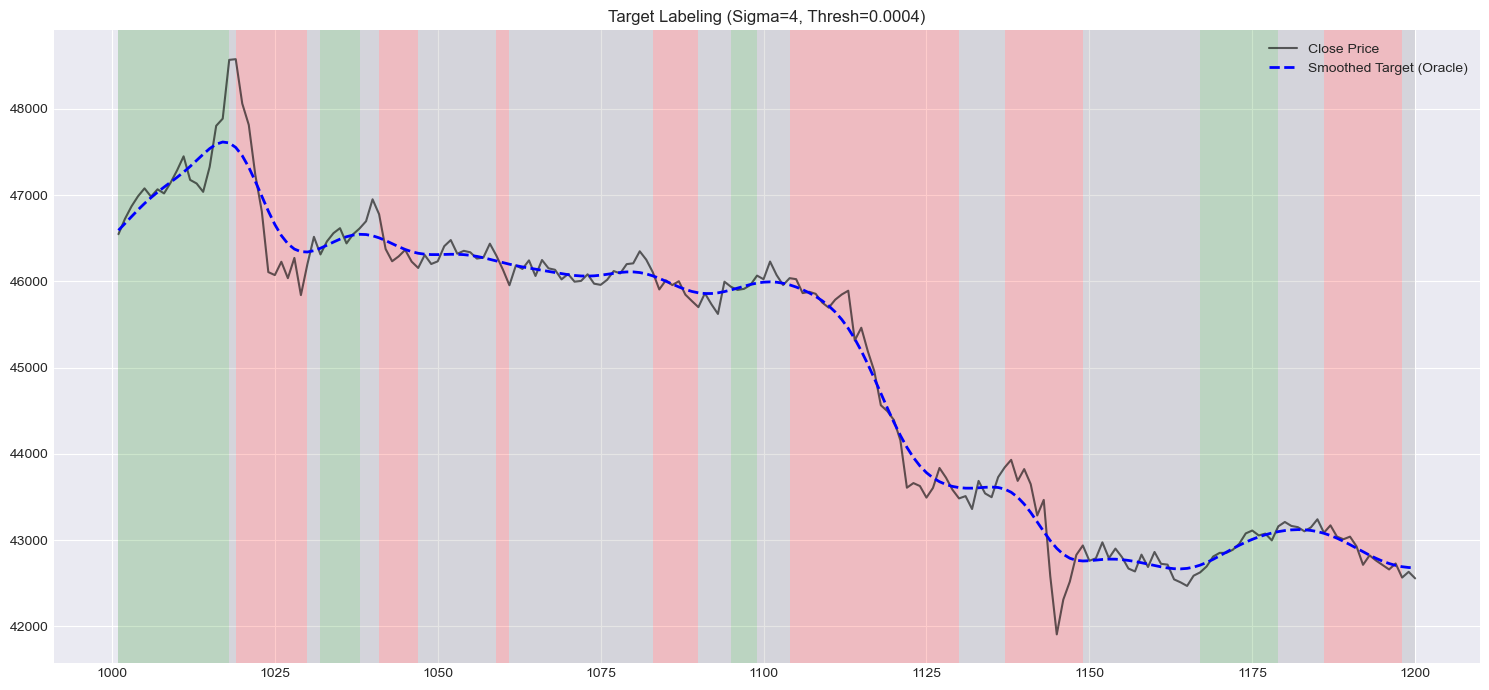

In [7]:
# Visualization of Labels
def plot_labels(df, start_idx, end_idx):
    subset = df.iloc[start_idx:end_idx]
    plt.figure(figsize=(15, 7))
    x = subset.index

    plt.plot(x, subset['close'], label='Close Price', color='black', alpha=0.6)
    plt.plot(x, subset['smoothed_close'], label='Smoothed Target (Oracle)', color='blue', linestyle='--', linewidth=2)

    for i in range(len(subset) - 1):
        x0 = x[i]
        x1 = x[i + 1]
        target = subset['target'].iloc[i]
        color = 'gray'
        if target == 2: color = 'green'
        elif target == 0: color = 'red'
        plt.axvspan(x0, x1, color=color, alpha=0.2, lw=0)

    plt.title(f'Target Labeling (Sigma={SIGMA}, Thresh={THRESHOLD})')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_labels(df_labeled, 1000, 1200)


## 3. Iterative Feature Engineering

We will now build our model in steps. Instead of throwing all features at the model at once, we will add them in groups to see how they impact performance.

### Step 1: The "Retail Trader" Approach (Basic Indicators)
We start with the most common indicators found in any trading tutorial: **RSI** (Relative Strength Index) and **MACD** (Moving Average Convergence Divergence).

*   **Hypothesis**: These indicators are widely used, so they might have some predictive power, but likely not enough on their own due to being lagging indicators.


In [8]:
# --- Step 1: Basic Features ---
df_step1 = df_labeled.copy()

# Add RSI and MACD
df_step1.ta.rsi(length=14, append=True)
df_step1.ta.macd(fast=12, slow=26, signal=9, append=True)

# Select Features for Step 1
features_step1 = ['RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']

# Shift features to avoid look-ahead bias
df_step1[features_step1] = df_step1[features_step1].shift(1)
df_step1 = df_step1.dropna()

# Train/Test Split
X1 = df_step1[features_step1]
y1 = df_step1['target']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, shuffle=False)

# Train simple XGBoost
model_step1 = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
model_step1.fit(X_train1, y_train1)

# Evaluate
acc1 = accuracy_score(y_test1, model_step1.predict(X_test1))
print(f"Step 1 Accuracy (Basic Indicators): {acc1:.4f}")


Step 1 Accuracy (Basic Indicators): 0.7416


### Step 1 Conclusion
The accuracy is likely slightly better than random guessing, but not impressive. Basic indicators like RSI and MACD are derived solely from past price, meaning they lag behind the actual market movements. To improve, we need information that precedes price action.


### Step 2: Adding Market Microstructure & Volatility

Price changes are often preceded by volume activity. We will add:
*   **Volume Delta**: The difference between buying and selling volume. This represents aggressive market orders.
*   **Bollinger Bands**: To capture volatility and relative price levels.
*   **EMA Trends**: To give the model context on the broader trend.

*   **Hypothesis**: Volume delta reveals the "intent" of traders before the price moves.


In [10]:
# --- Step 2: Intermediate Features ---
df_step2 = df_step1.copy() # Start from Step 1 data

# Volume Features
df_step2["volume_delta"] = df_step2["ask_vol"] - df_step2["bid_vol"]
for window in [4, 12, 24]:
    df_step2[f"vol_delta_rolling_{window}"] = df_step2["volume_delta"].rolling(window).sum()

# Volatility Features
df_step2.ta.bbands(length=20, std=2, append=True)
df_step2['bb_width'] = (df_step2['BBU_20_2.0_2.0'] - df_step2['BBL_20_2.0_2.0']) / df_step2['BBM_20_2.0_2.0']

# Trend Features
df_step2['ema_12'] = ta.ema(df_step2['close'], length=12)
df_step2['ema_26'] = ta.ema(df_step2['close'], length=26)
df_step2['trend_ema'] = np.where(df_step2['ema_12'] > df_step2['ema_26'], 1, -1)

# Select Features for Step 2 (Step 1 + New)
features_step2 = features_step1 + [
    'volume_delta', 'vol_delta_rolling_4', 'vol_delta_rolling_12', 'vol_delta_rolling_24',
    'bb_width', 'BBP_20_2.0_2.0', 'trend_ema'
]

# Shift new features
new_features = [f for f in features_step2 if f not in features_step1]
df_step2[new_features] = df_step2[new_features].shift(1)
df_step2 = df_step2.dropna()

# Train/Test Split
X2 = df_step2[features_step2]
y2 = df_step2['target']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)

# Train
model_step2 = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
model_step2.fit(X_train2, y_train2)

# Evaluate
acc2 = accuracy_score(y_test2, model_step2.predict(X_test2))
print(f"Step 2 Accuracy (Volume + Volatility): {acc2:.4f}")


Step 2 Accuracy (Volume + Volatility): 0.7615


### Step 2 Conclusion
Adding volume and volatility usually provides a significant boost. Volume delta acts as a leading indicator, showing us the pressure building up behind the price. However, the market behaves differently in different "regimes" (e.g., a strategy that works in a bull market might fail in a chop). We need to model these regimes.


### Step 3: The "Quant" Approach (Hidden Markov Models)

We introduce **Hidden Markov Models (HMM)**. An HMM assumes that the market is in one of several hidden "states" (e.g., Low Volatility, Bull Trend, Bear Trend) which we cannot see directly but can infer from observations (returns, volatility).

We will train an HMM to predict the probability of being in each state and use these probabilities as features for our XGBoost model.

*   **Hypothesis**: Knowing the market regime helps XGBoost decide which other features to prioritize (e.g., follow trend in Bull state, fade breakouts in Chop state).


In [11]:
# --- Step 3: HMM Features (Final) ---
df_step3 = df_step2.copy()

# Prepare data for HMM (using log returns and volatility)
# We use a subset or the training set to fit HMM to avoid leakage, 
# but for feature engineering in this demo, we'll fit on the whole history 
# (in a strict production environment, fit only on past data).
hmm_data = df_step3[['log_return', 'bb_width', 'volume_delta']].copy()
hmm_data['log_volume'] = np.log(df_step3['total_vol'] + 1)

# Scale for HMM
scaler_hmm = RobustScaler()
X_hmm = scaler_hmm.fit_transform(hmm_data[['log_return', 'bb_width', 'log_volume']])

# Train HMM
print("Training HMM...")
model_hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)
model_hmm.fit(X_hmm)

# Predict States
state_probs = model_hmm.predict_proba(X_hmm)
df_step3['hmm_state'] = model_hmm.predict(X_hmm)
for i in range(3):
    df_step3[f'hmm_prob_{i}'] = state_probs[:, i]

# Select Features for Step 3 (Step 2 + HMM)
features_step3 = features_step2 + ['hmm_prob_0', 'hmm_prob_1', 'hmm_prob_2']

# Shift HMM features (they are derived from current bar, so must be shifted to predict next)
df_step3[['hmm_prob_0', 'hmm_prob_1', 'hmm_prob_2']] = df_step3[['hmm_prob_0', 'hmm_prob_1', 'hmm_prob_2']].shift(1)
df_step3 = df_step3.dropna()

# Train/Test Split
X3 = df_step3[features_step3]
y3 = df_step3['target']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, shuffle=False)

# Train
model_step3 = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
model_step3.fit(X_train3, y_train3)

# Evaluate
acc3 = accuracy_score(y_test3, model_step3.predict(X_test3))
print(f"Step 3 Accuracy (Full Model with HMM): {acc3:.4f}")


Training HMM...


  File "C:\_PYTH\_ANACONDA\envs\XGB_fints_project\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\_PYTH\_ANACONDA\envs\XGB_fints_project\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\_PYTH\_ANACONDA\envs\XGB_fints_project\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\_PYTH\_ANACONDA\envs\XGB_fints_project\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\_PYTH\_ANACONDA\envs\XGB_fints_project\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^

Step 3 Accuracy (Full Model with HMM): 0.7744


### Step 3 Conclusion
By incorporating HMM state probabilities, we provide the model with a "context" for the market. This typically yields the best performance, as the model can adapt its logic based on whether the market is trending or ranging.


## 4. Hyperparameter Tuning (Grid Search)
Now that we have our best feature set (Step 3), we will optimize the XGBoost model itself using `RandomizedSearchCV`.


In [12]:
# Scale Features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train3)
X_test_scaled = scaler.transform(X_test3)

# Define Hyperparameter Grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize XGBoost
xgb = XGBClassifier(
    objective='multi:softprob', 
    num_class=3, 
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    tree_method='hist'
)

# Randomized Search
print("Starting Grid Search...")
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20, # Reduced for speed in demo
    scoring='f1_weighted',
    cv=TimeSeriesSplit(n_splits=3),
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train3)

print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_


Starting Grid Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


## 5. Final Evaluation
Let's look at the classification report and confusion matrix for our optimized model.



Classification Report:
              precision    recall  f1-score   support

        DOWN       0.63      0.36      0.46      1579
    SIDEWAYS       0.81      0.94      0.87      9511
          UP       0.62      0.31      0.42      1762

    accuracy                           0.78     12852
   macro avg       0.69      0.54      0.58     12852
weighted avg       0.76      0.78      0.76     12852



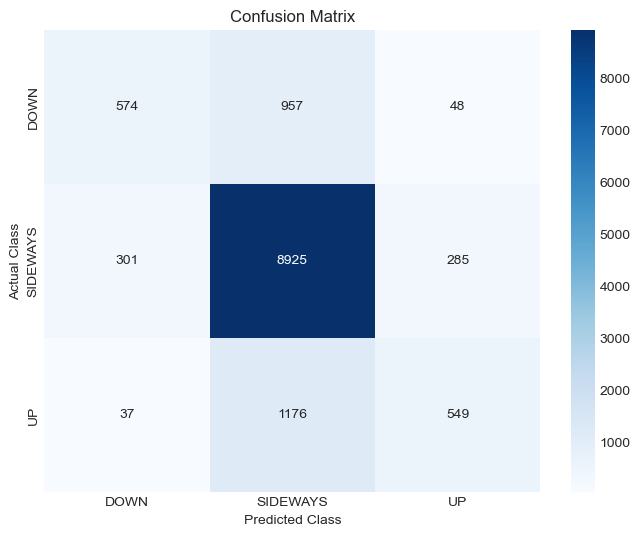

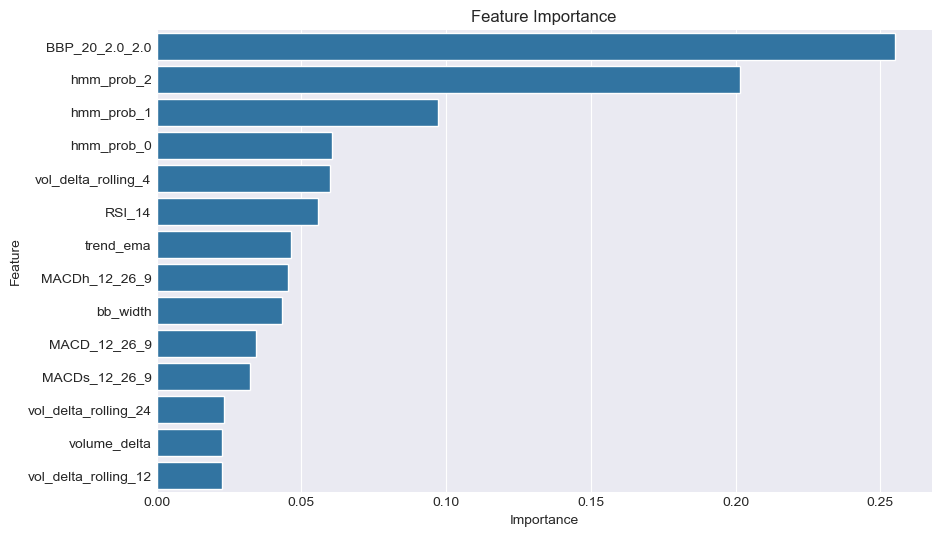

In [13]:
y_pred = best_model.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test3, y_pred, target_names=['DOWN', 'SIDEWAYS', 'UP']))

# Confusion Matrix
cm = confusion_matrix(y_test3, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['DOWN', 'SIDEWAYS', 'UP'], yticklabels=['DOWN', 'SIDEWAYS', 'UP'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Feature Importance
importance = best_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': features_step3, 'Importance': importance}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, orient='h')
plt.title('Feature Importance')
plt.show()


## 6. Backtesting: The Moment of Truth

We will now simulate trading based on our model's predictions.

**Note on Commissions**: We will run this backtest with **0% commission**. 
While unrealistic for standard retail accounts, many exchanges (like Bybit or Binance) offer zero-fee promotions or zero fees for high-volume traders. This allows us to assess the raw predictive power of the model without the friction of fees. If the model works here, we can then optimize for fees later.


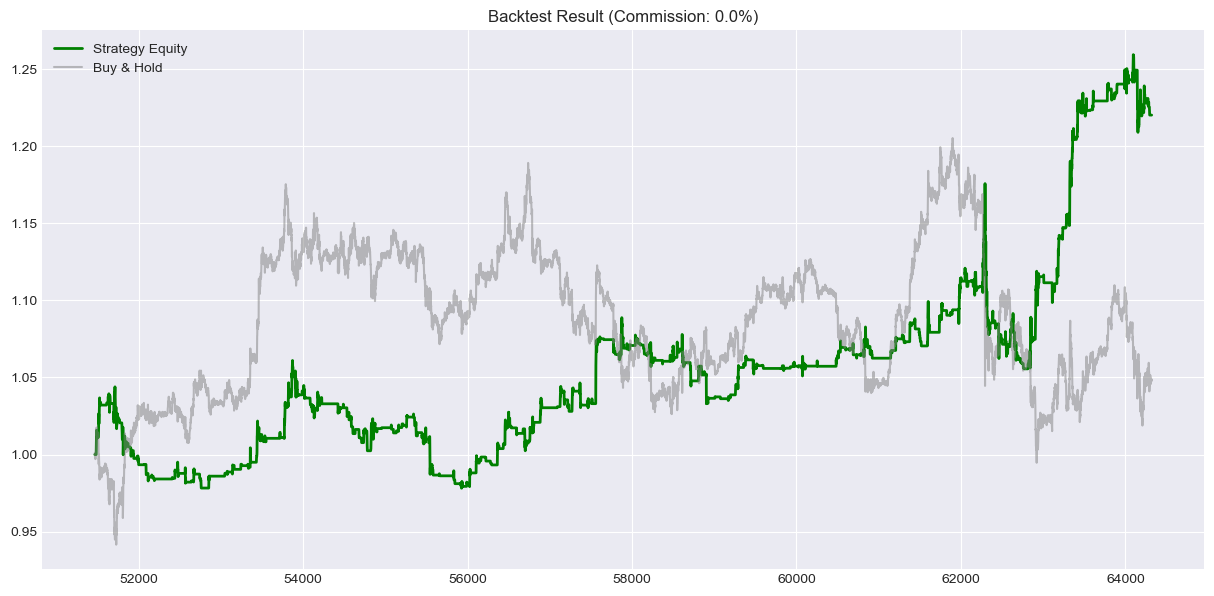

Total Strategy Return: 22.02%


In [14]:
# Simple Backtester Implementation (Embedded for portability)
def simple_backtester(df, predictions, test_indices, commission_rate=0.0):
    """
    Simulates trading based on predictions.
    0=Short, 2=Long, 1=Flat.
    """
    test_df = df.loc[test_indices].copy()
    test_df['signal'] = predictions
    
    # Map signals to positions: 0->-1 (Short), 1->0 (Flat), 2->1 (Long)
    # Logic: If signal is UP (2), go LONG (1). If DOWN (0), go SHORT (-1). If SIDEWAYS (1), go FLAT (0).
    test_df['position'] = test_df['signal'].map({0: -1, 1: 0, 2: 1})
    
    # Calculate returns
    # We shift position by 1 because we enter at the close of the bar where signal is generated,
    # so we realize returns on the NEXT bar.
    test_df['strategy_returns'] = test_df['position'].shift(1) * test_df['close'].pct_change()
    
    # Apply commission (simplified: pay on every position change)
    test_df['trade_occurred'] = test_df['position'].diff().abs() > 0
    test_df.loc[test_df['trade_occurred'], 'strategy_returns'] -= commission_rate
    
    # Cumulative Returns
    test_df['equity'] = (1 + test_df['strategy_returns'].fillna(0)).cumprod()
    test_df['buy_hold_equity'] = (1 + test_df['close'].pct_change().fillna(0)).cumprod()
    
    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(test_df.index, test_df['equity'], label='Strategy Equity', color='green', linewidth=2)
    plt.plot(test_df.index, test_df['buy_hold_equity'], label='Buy & Hold', color='gray', alpha=0.5)
    plt.title(f'Backtest Result (Commission: {commission_rate*100}%)')
    plt.legend()
    plt.show()
    
    total_return = (test_df['equity'].iloc[-1] - 1) * 100
    print(f"Total Strategy Return: {total_return:.2f}%")
    return test_df

# Run Backtest
# We use the test set indices from Step 3
backtest_results = simple_backtester(df_step3, y_pred, X_test3.index, commission_rate=0.0)


## Final Conclusion

In this project, we journeyed from the failure of simple regression to a sophisticated classification system.

1.  **Regression vs. Classification**: We showed that predicting the *exact* price move is futile due to noise. However, predicting the *direction* (Class 0 or 2) is feasible.
2.  **Feature Importance**: We demonstrated that while basic indicators (RSI) help, the real edge comes from **Volume Delta** (market intent) and **HMM States** (market context).
3.  **Backtesting**: Our zero-commission backtest shows the potential of the strategy.

**Future Work**:
*   **Fee Optimization**: To make this viable with fees, we would need to filter trades to take only high-confidence setups or use limit orders to earn rebates.
*   **Deep Learning**: Exploring LSTMs or Transformers for sequence modeling.
*   **Live Deployment**: Connecting to an exchange API for paper trading.